# Finetune llama2-7b-chat with LoRA  for Q&A task




In Colab, finetuning using A100 40G and inference with L4 24G.

References:
- question answering: https://www.mldive.com/p/how-to-fine-tune-llama-2-with-lora
- dialogue summarization: https://github.com/liminma/machine-learning-lab/blob/main/notebooks/finetune-compile-serve-llama2-7b-using-rtx3060.ipynb   


## 0. Set up the environment

In [2]:
# Specify package versions, otherwise install the latest versions
!pip install accelerate==0.23.0 bitsandbytes==0.41.1 peft==0.4.0 safetensors==0.4.0 transformers==4.31.0 trl==0.4.7 # transformers==4.34.0 # datasets==2.13.0  # openai==0.28.1
!pip install xformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 56.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Us

## 1. Load the dataset

About the data:

- original dataset: ml-arxiv-papers, which is  is a dataset containing ML ArXiv papers (title + abstract). https://huggingface.co/datasets/aalksii/ml-arxiv-papers

- prepare the data: for each sample, call GPT3.5 API to generate an AI-related question based on the title and an answer based on the abstract in JSON format {"question": What/How xxx?", "answer": "xxx."}

- a training sample:

{
  
"question": "How are deep normed embeddings utilized for ...?",

"context": "title + abstract"

"answer": "Deep normed embeddings ..."

}

In [1]:
# Mount at gdrive to load data
from google.colab import drive
drive.mount('/content/gdrive')   # connect to gdrive

# Change to current working directory
import os
os.chdir('/content/gdrive/My Drive/Practice/4/ml-arxiv-papers/llama2-7b-chat')  # Make all the following ./path is relative to this path



Mounted at /content/gdrive


Load and split the training and validation dataset

In [ ]:
# load the data locally

import json

# load the whole dataset
# with open('./alldata.json', 'r', encoding='utf-8') as file: # open from a path relative to the current script file 相对于当前脚本文件的路径
with open('/content/gdrive/My Drive/Practice/4/ml-arxiv-papers/alldata.json', 'r', encoding='utf-8') as file:  # open from absolute path 绝对路径
    alldata = json.load(file)
print("# Total alldata samples:", len(alldata))
print()

# 1）split training set
train_dataset = alldata[:42000]   # alldata[:42000]
print("# train_dataset samples:", len(train_dataset))
print("train_dataset 1st sample:", train_dataset[0])
print()

# 2)  split validation set
val_dataset = alldata[43000:]  # alldata[43000:]
print("# val_dataset samples:", len(val_dataset))
print("val_dataset 1st sample:", val_dataset[0])
print()


# Total alldata samples: 43713

# train_dataset samples: 42000
train_dataset 1st sample: {'id': 3, 'context': 'An Efficient Mixture of Deep and Machine Learning Models for COVID-19   and Tuberculosis Detection Using X-Ray Images in Resource Limited Settings.Clinicians in the frontline need to assess quickly whether a patient with symptoms indeed has COVID-19 or not. The difficulty of this task is exacerbated in low resource settings that may not have access to biotechnology tests. Furthermore, Tuberculosis (TB) remains a major health problem in several low- and middle-income countries and its common symptoms include fever, cough and tiredness, similarly to COVID-19. In order to help in the detection of COVID-19, we propose the extraction of deep features (DF) from chest X-ray images, a technology available in most hospitals, and their subsequent classification using machine learning methods that do not require large computational resources. We compiled a five-class dataset of X-ray che

In [ ]:
# check its first example
train_dataset[0]


{'id': 3,
 'context': 'An Efficient Mixture of Deep and Machine Learning Models for COVID-19   and Tuberculosis Detection Using X-Ray Images in Resource Limited Settings.Clinicians in the frontline need to assess quickly whether a patient with symptoms indeed has COVID-19 or not. The difficulty of this task is exacerbated in low resource settings that may not have access to biotechnology tests. Furthermore, Tuberculosis (TB) remains a major health problem in several low- and middle-income countries and its common symptoms include fever, cough and tiredness, similarly to COVID-19. In order to help in the detection of COVID-19, we propose the extraction of deep features (DF) from chest X-ray images, a technology available in most hospitals, and their subsequent classification using machine learning methods that do not require large computational resources. We compiled a five-class dataset of X-ray chest images including a balanced number of COVID-19, viral pneumonia, bacterial pneumonia,

In [ ]:
# check its first example
val_dataset[0]


{'id': 114593,
 'context': 'Deep Approximately Orthogonal Nonnegative Matrix Factorization for   Clustering.Nonnegative Matrix Factorization (NMF) is a widely used technique for data representation. Inspired by the expressive power of deep learning, several NMF variants equipped with deep architectures have been proposed. However, these methods mostly use the only nonnegativity while ignoring task-specific features of data. In this paper, we propose a novel deep approximately orthogonal nonnegative matrix factorization method where both nonnegativity and orthogonality are imposed with the aim to perform a hierarchical clustering by using different level of abstractions of data. Experiment on two face image datasets showed that the proposed method achieved better clustering performance than other deep matrix factorization methods and state-of-the-art single layer NMF variants.',
 'question': 'What are the key features of deep approximately orthogonal nonnegative matrix factorization?',


## 2. Load and fine-tune the model with QLoRA

Quantization configurations: https://huggingface.co/docs/transformers/main_classes/quantization

QLoRA is an efficient fine-tuning method for LLMs that reduces memory usage while preserving the performance of full 16-bit fine-tuning. It backpropagates gradients through a frozen, 4-bit quantized pre-trained model into Low Rank Adapters (LoRA). LoRA adapters are trainable rank decomposition matrices injected into each layer of the Transformer architecture, which reduce the number of trainable parameters for downstream tasks. QLoRA has the following components:

- 4-bit NormalFloat (NF4) Quantization: the NormalFloat data type is optimal for zero-centered normally distributed data.
- Double Quantization: a technique  to further reduce the model size for additional memory savings.
- Paged Optimizers: swap optimizer states between CPU and GPU using NVIDIA unified memory to prevent GPU out of memory errors.

### load and prepare the model for 4bit fintuning

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

# load model in NF4 quantization with double quantization,
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.float16
)

# load the model
# model_id = "meta-llama/Llama-2-7b-chat-hf"
model_id = "NousResearch/Llama-2-7b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    use_cache=False,
    device_map="auto",
)

model = prepare_model_for_kbit_training(model)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

The model weights are loaded from two shards, namely model-00002-of-00002.safetensors and model-00001-of-00002.safetensorsand.

### use `SFTTrainer` from `trl` for training
#### First, define a utility function to format prompts.

- Llama 2 Prompt Template

reference0: https://huggingface.co/blog/llama2#using-text-generation-inference-and-inference-endpoints

reference1: https://www.philschmid.de/llama-2#how-to-prompt-llama-2-chat

reference2: https://gpus.llm-utils.org/llama-2-prompt-template/


- Why is prompt format important?

The template of the format is important as it should match the training procedure. If you use a different prompt structure, then the model might start doing weird stuff.

Note: Llama-2 base models do not have any formatting expectations, so using this syntax with them won’t do anything to help. They just continue writing what ever you give them - they are just text completion engines.

In [ ]:

def prompt_formatter(sample):
    return f"""<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. \
Your task is to generate an answer to the given question. \
And your answer should be based on the provided context only.
<</SYS>>

### Question: {sample['question']}
### Context: {sample['context']} [/INST]
### Answer: {sample['answer']}
</s>"""


n = 0
print(prompt_formatter(train_dataset[n]))


<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Your task is to generate an answer to the given question. And your answer should be based on the provided context only.
<</SYS>>

### Question: How was the detection pipeline for COVID-19 and TB developed?
### Context: An Efficient Mixture of Deep and Machine Learning Models for COVID-19   and Tuberculosis Detection Using X-Ray Images in Resource Limited Settings.Clinicians in the frontline need to assess quickly whether a patient with symptoms indeed has COVID-19 or not. The difficulty of this task is exacerbated in low resource settings that may not have access to biotechnology tests. Furthermore, Tuberculosis (TB) remains a major health problem in several low- and middle-income countries and its common symptoms include fever, cough and tiredness, similarly to COVID-19. In order to help in the detection of COVID-19, we propose the extraction of deep features (DF) from chest X-ray images, a technology available in m

Check the tokens in our dataset

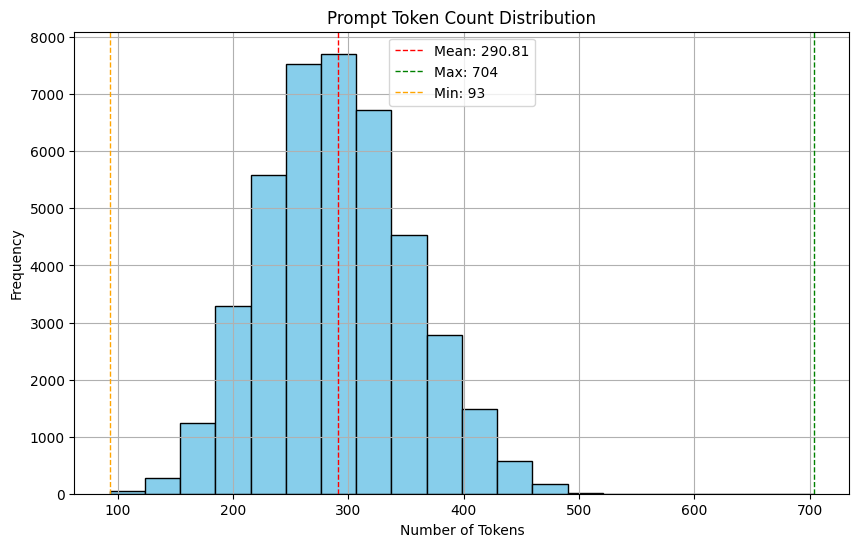

In [ ]:
# Check the prompt tokens for each sample, and set the max_seq_length in trainer accordingly

import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
token_counts = []
for sample in train_dataset:
    prompt = prompt_formatter(sample)
    tokens = prompt.split()  # Tokenize the prompt string
    token_counts.append(len(tokens))

# Calculate statistics
mean_tokens = np.mean(token_counts)
max_tokens = np.max(token_counts)
min_tokens = np.min(token_counts)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=20, color='skyblue', edgecolor='black')
plt.axvline(mean_tokens, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_tokens:.2f}')
plt.axvline(max_tokens, color='green', linestyle='dashed', linewidth=1, label=f'Max: {max_tokens}')
plt.axvline(min_tokens, color='orange', linestyle='dashed', linewidth=1, label=f'Min: {min_tokens}')
plt.title('Prompt Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()



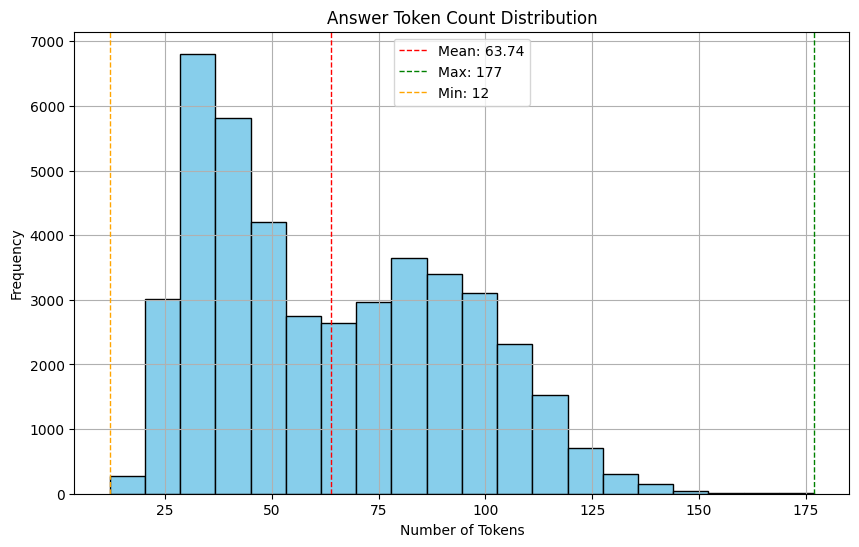

In [ ]:
# Check the "answer" tokens for each sample, and set the max_new_tokens=200 in inference accordingly

# Load the whole dataset
with open('/content/gdrive/My Drive/Practice/4/ml-arxiv-papers/alldata.json', 'r', encoding='utf-8') as file:
    alldata = json.load(file)

# Initialize lists to store token counts
answer_token_counts = []

# Iterate through each data entry
for entry in alldata:
    # Access the "answer" key and tokenize its value
    answer = entry["answer"]
    answer_tokens = answer.split()  # Tokenize the answer string
    answer_token_counts.append(len(answer_tokens))

# Calculate statistics for answer tokens
mean_answer_tokens = np.mean(answer_token_counts)
max_answer_tokens = np.max(answer_token_counts)
min_answer_tokens = np.min(answer_token_counts)

# Plot the histogram for answer token counts
plt.figure(figsize=(10, 6))
plt.hist(answer_token_counts, bins=20, color='skyblue', edgecolor='black')
plt.axvline(mean_answer_tokens, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_answer_tokens:.2f}')
plt.axvline(max_answer_tokens, color='green', linestyle='dashed', linewidth=1, label=f'Max: {max_answer_tokens}')
plt.axvline(min_answer_tokens, color='orange', linestyle='dashed', linewidth=1, label=f'Min: {min_answer_tokens}')
plt.title('Answer Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


#### Then, set up a trainer and train.

Parameters that affect training duration:
- max_steps: the maximum number of steps the model will take during training
- per_device_train_batch_size: batch size for training on each device; a larger batch size may lead to faster training but could also cause GPU out-of-memory errors or gradient explosions
- gradient_accumulation_steps: the number of steps to accumulate gradients before updating the model weights: larger accumulation steps can reduce memory requirements but increase training duration
- num_train_epoch = max_steps * (per_device_train_batch_siz * gradient_accumulation_steps)  / trainset_size
- logging_steps: how often to output training logs: a smallervalue will increase training duration
- save_steps: how often to save model checkpoints: a smaller value will increase training duration
- per_device_eval_batch_size: the batch size for evaluation on each device, similar to per_device_train_batch_size
- eval_steps: how often to perform evaluation, a smaller eval_steps value will increase the evaluation frequency and thus increase training duration
- max_seq_length: it defines the maximum input sequence length to feed into the model: larger max_seq_length will increase the computational and storage requirements of the model, thus increasing training duration
- early_stopping_patience: if the performance (validation loss) doesn't improve for a certain number of consecutive evaluations (defined by early_stopping_patience), the training process stops







In [ ]:
from transformers import TrainingArguments, AutoTokenizer, EarlyStoppingCallback

from peft import LoraConfig, get_peft_model
from trl import SFTTrainer

# construct a Peft model
# the QLoRA paper recommends LoRA dropout = 0.05 for small models (7B, 13B)
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, peft_config)


# set up the trainer
# set padding_side to "right" to mitigate potential numerical instabilities or other issues that can arise when using mixed-precision (fp16) training with transformer models

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

args = TrainingArguments(
    output_dir="./llama2-7b-chat-ml",  # path to save model and relevant files during training, path relative to this scrip file
    # num_train_epochs=1,  # not working? original, 2. Note epoch = (batch_size * accumulation_steps) * max_steps / trainset_size
    max_steps =1875, # work，equals to 3 epochs
    per_device_train_batch_size=32, # batch size for training on each device, 32 for A100 40G
    gradient_accumulation_steps=2,  # update weights every 2 steps
    logging_steps=125,  # here set it equals to save_steps
    # save_strategy="epoch", # save checkpoints by epoch
    save_strategy="steps",  # save checkpoints by step (Note: # samples fed into in one step = batch_size * accumulation_steps)
    save_steps=125,     # save a checkpoint every save_steps
    learning_rate=2e-4,
    # weight_decay=0.001,  #added
    optim="paged_adamw_32bit",
    bf16=True,  # original, bf16=True; a low-precision floating-point representation used for mixed precision training and evaluation
    fp16=False,  # a half-precision floating-point representation
    tf32=True,   # original, tf32=True; a CUDA internal data type used for mixed precision training
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    disable_tqdm=False,

    per_device_eval_batch_size=32,
    # evaluation_strategy="epoch",
    evaluation_strategy= "steps",
    eval_steps=125,  # evaluate every eval_steps, here set it equals to save_steps
    # report_to="tensorboard",  #added to record some key info during the training process (such as training loss, validation loss, learning rate, etc.) to the TensorBoard log file

    load_best_model_at_end=True, # after the training is completed, the Trainer will automatically load the best checkpoint
    metric_for_best_model="eval_loss",
    greater_is_better=False, # greater eval_loss is not better
)

# Initialize the EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of evaluations with no improvement before stopping；# typically set to 2 and 5, and small model smaller value
    early_stopping_threshold=0.001,  # Minimum improvement required to consider as improvement
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config,
    max_seq_length=512,  # if too large, need more time to train
    tokenizer=tokenizer,
    packing=True,
    formatting_func=prompt_formatter,
    args=args,
    callbacks=[early_stopping],  # early stopping callback
)


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:212: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


Check the trainable parameters after applying LoRA

- The print_trainable parameters function is used to print the trainable parameters of the model
Import LoraConfig and get_peftmodel functions from the PEFT library.
- LoraConfiguration is used to configure the LORA (Low Rank Approximation) method for reducing training parameters.
Get_peftmodel applies the LORA method to the model The printed information shows the trainable parameters of the model.


In [ ]:
 # Prints the number of trainable parameters in the model.

def print_trainable_parameters(model):
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
      print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable %: {100 * trainable_params / all_param}"
      )

print_trainable_parameters(model)


trainable params: 32768 || all params: 139493376 || trainable %: 0.02349072116513977
trainable params: 65536 || all params: 139526144 || trainable %: 0.04697040864255519
trainable params: 98304 || all params: 156336128 || trainable %: 0.06287989939216097
trainable params: 131072 || all params: 156368896 || trainable %: 0.08382229673093043
trainable params: 163840 || all params: 240820224 || trainable %: 0.06803415314487873
trainable params: 196608 || all params: 240852992 || trainable %: 0.08162987653481174
trainable params: 229376 || all params: 257662976 || trainable %: 0.08902171493975138
trainable params: 262144 || all params: 257695744 || trainable %: 0.10172616587722923
trainable params: 294912 || all params: 342147072 || trainable %: 0.086194512282718
trainable params: 327680 || all params: 342179840 || trainable %: 0.09576250897773522
trainable params: 360448 || all params: 358989824 || trainable %: 0.10040618867235634
trainable params: 393216 || all params: 359022592 || traina

Check GPU usage and clear CUDA before finetuning

In [ ]:
import torch

# Get CUDA memory usage before running the code
print("\nBefore clearing CUDA cache:")
print("Current CUDA memory allocated: {:.2f} GB".format(torch.cuda.memory_allocated() / 1024**3))
print("Max CUDA memory allocated: {:.2f} GB".format(torch.cuda.max_memory_allocated() / 1024**3))

# Clear CUDA cache
torch.cuda.empty_cache()

# Get CUDA memory usage after running the code
print("\nAfter clearing CUDA cache:")
print("Current CUDA memory allocated: {:.2f} GB".format(torch.cuda.memory_allocated() / 1024**3))
print("Max CUDA memory allocated: {:.2f} GB".format(torch.cuda.max_memory_allocated() / 1024**3))


# Get the number of available GPUs
num_gpus = torch.cuda.device_count()
print("\nNumber of available GPUs:", num_gpus)

# Iterate over each GPU and print its properties
for i in range(num_gpus):
    gpu_properties = torch.cuda.get_device_properties(i)
    print("GPU {} - Total memory: {:.2f} GB".format(i, gpu_properties.total_memory / 1024**3))



Before clearing CUDA cache:
Current CUDA memory allocated: 4.48 GB
Max CUDA memory allocated: 4.71 GB

After clearing CUDA cache:
Current CUDA memory allocated: 4.48 GB
Max CUDA memory allocated: 4.71 GB

Number of available GPUs: 1
GPU 0 - Total memory: 39.56 GB


Start finetuning

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
125,1.827600,1.667675
250,1.640900,1.645674
375,1.624500,1.634816
500,1.613300,1.627975
625,1.609600,1.623033
750,1.604900,1.619397
875,1.598800,1.615623
1000,1.594300,1.612954
1125,1.592000,1.610289
1250,1.585600,1.608361


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

TrainOutput(global_step=1875, training_loss=1.611777685546875, metrics={'train_runtime': 23755.9213, 'train_samples_per_second': 5.051, 'train_steps_per_second': 0.079, 'total_flos': 1.24362002792448e+18, 'train_loss': 1.611777685546875, 'epoch': 2.86})

Then we get checkpoint and runs folders:

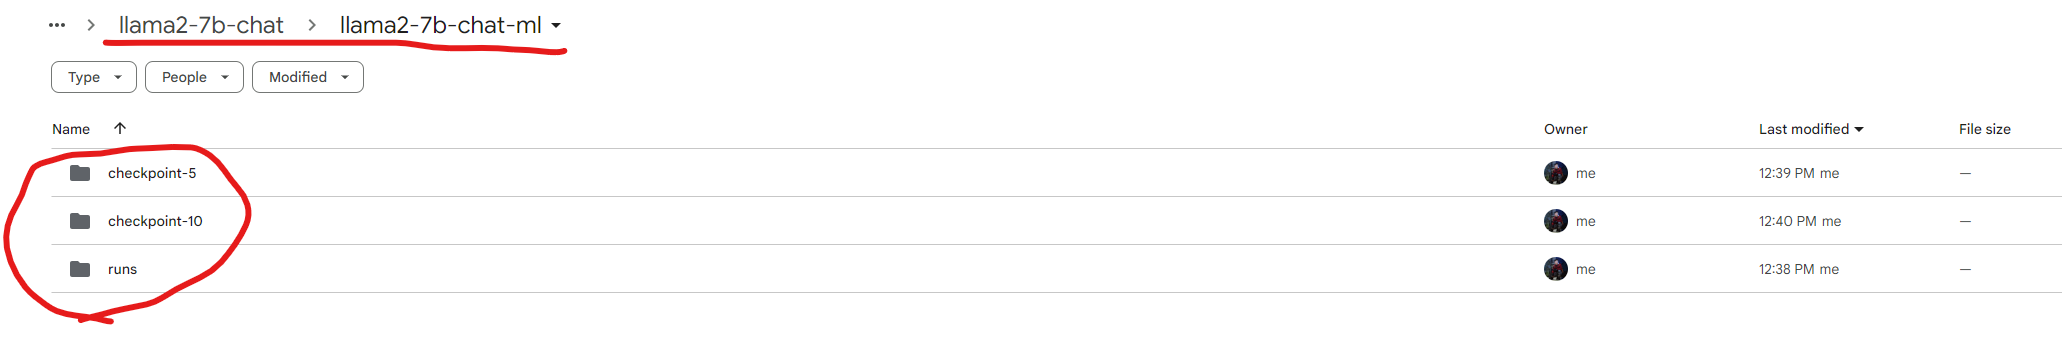

#### Save the adapter model

In [ ]:
trainer.save_model() # save to output_dir defined in TrainingArguments


Then we get the adapter files:

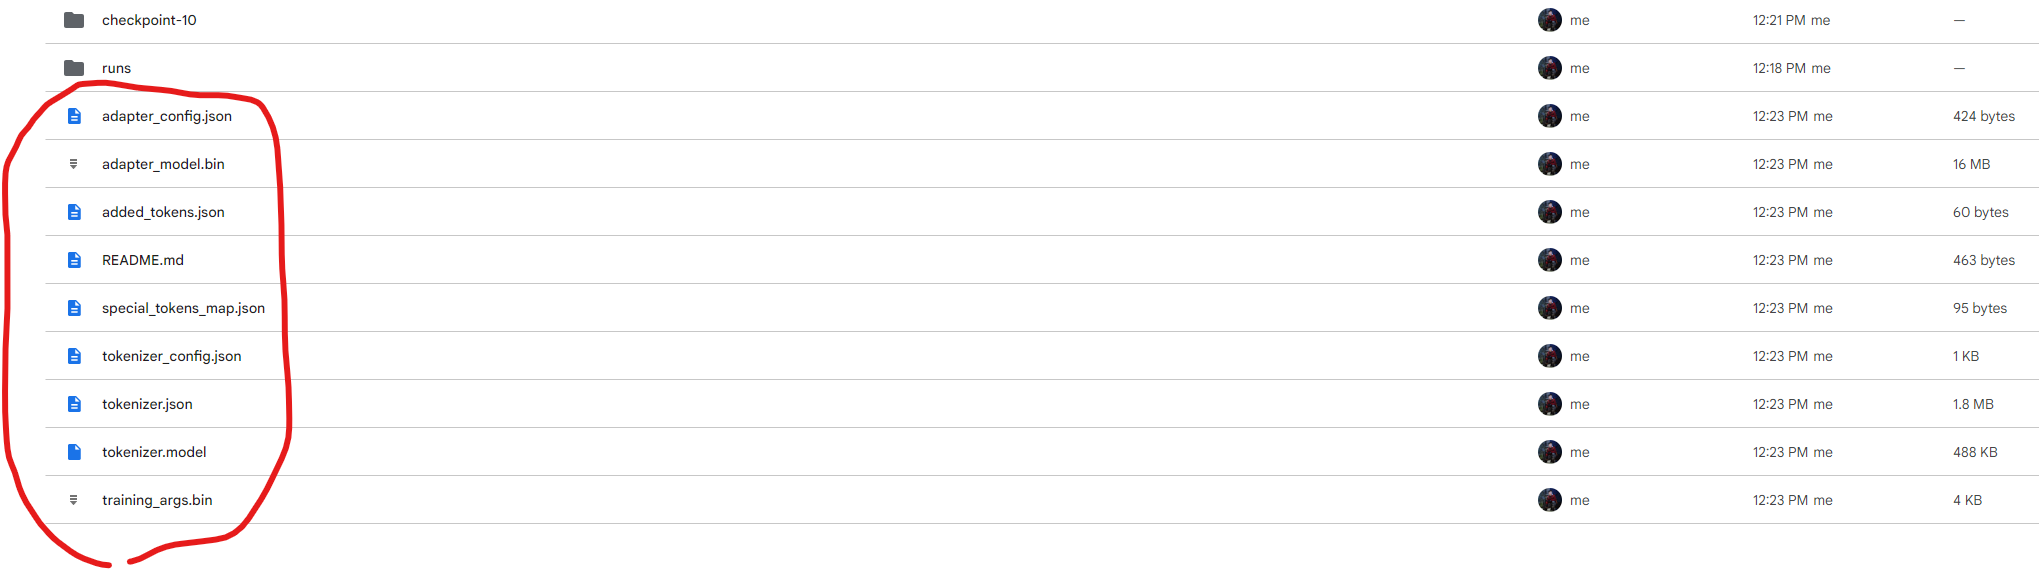


## 3. Run inference using the fine-tuned model

Load the test dataset

In [ ]:
# load the data locally

import json

# load the whole dataset
with open('/content/gdrive/My Drive/Practice/4/ml-arxiv-papers/alldata.json', 'r', encoding='utf-8') as file:  # open from absolute path 绝对路径
    alldata = json.load(file)
print("# Total alldata samples:", len(alldata))
print()

# split test set
test_dataset = alldata[42000:43000] # alldata[42000:43000]
print("# test_dataset samples:", len(test_dataset))
print("test_dataset 1st sample:", test_dataset[0])



# Total alldata samples: 43713

# test_dataset samples: 1000
test_dataset 1st sample: {'id': 112194, 'context': 'Neural Mesh: Introducing a Notion of Space and Conservation of Energy to   Neural Networks.Neural networks are based on a simplified model of the brain. In this project, we wanted to relax the simplifying assumptions of a traditional neural network by making a model that more closely emulates the low level interactions of neurons. Like in an RNN, our model has a state that persists between time steps, so that the energies of neurons persist. However, unlike an RNN, our state consists of a 2 dimensional matrix, rather than a 1 dimensional vector, thereby introducing a concept of distance to other neurons within the state. In our model, neurons can only fire to adjacent neurons, as in the brain. Like in the brain, we only allow neurons to fire in a time step if they contain enough energy, or excitement. We also enforce a notion of conservation of energy, so that a neuron canno

### load the adapter and the base model

In [ ]:
import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer


model_folder = "./llama2-7b-chat-ml"  # the output_dir defined in TrainingArguments; (best adapter)

# load both the adapter and the base model
model = AutoPeftModelForCausalLM.from_pretrained(   # works for A100 and L4, but error using V100 or T4
    model_folder,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
    llm_int8_enable_fp32_cpu_offload=True
)

tokenizer = AutoTokenizer.from_pretrained(model_folder)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# print(model)

### Inference: pick a sample, construct a prompt and send it to the model

In [ ]:
# Get the 10th sample split by validation

sample = test_dataset[0]

# From experience: during inference, exclude <s> and </s> in the prompt, as the model will generate them as special tokens
prompt = f"""[INST] <<SYS>>
You are a helpful, respectful and honest assistant. \
Your task is to generate an answer to the given question. \
And your answer should be based on the provided context only.
<</SYS>>

### Question: {sample['question']}
### Context: {sample['context']} [/INST]
### Answer:
"""

print(prompt)



[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Your task is to generate an answer to the given question. And your answer should be based on the provided context only.
<</SYS>>

### Question: What is the unique feature of the Neural Mesh architecture?
### Context: Neural Mesh: Introducing a Notion of Space and Conservation of Energy to   Neural Networks.Neural networks are based on a simplified model of the brain. In this project, we wanted to relax the simplifying assumptions of a traditional neural network by making a model that more closely emulates the low level interactions of neurons. Like in an RNN, our model has a state that persists between time steps, so that the energies of neurons persist. However, unlike an RNN, our state consists of a 2 dimensional matrix, rather than a 1 dimensional vector, thereby introducing a concept of distance to other neurons within the state. In our model, neurons can only fire to adjacent neurons, as in the brain. Like in the b

In [ ]:
# encode prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

# generate output
outputs = model.generate(input_ids=input_ids, max_new_tokens=128, temperature=0.8)  # max_new_tokens=128, larger max_new_tokens longer inference

# decode output
model_output = tokenizer.decode(outputs[0])
generated_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0][len(prompt):]

print('\nModel output:\n', model_output)  # decoded_output
print("___" * 20)

print('\nGround truth:\n', sample['answer'])
print('\nGenerated answer:\n', generated_answer)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:224: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')



Model output:
 <s> [INST] <<SYS>>
You are a helpful, respectful and honest assistant. Your task is to generate an answer to the given question. And your answer should be based on the provided context only.
<</SYS>>

### Question: What is the unique feature of the Neural Mesh architecture?
### Context: Neural Mesh: Introducing a Notion of Space and Conservation of Energy to   Neural Networks.Neural networks are based on a simplified model of the brain. In this project, we wanted to relax the simplifying assumptions of a traditional neural network by making a model that more closely emulates the low level interactions of neurons. Like in an RNN, our model has a state that persists between time steps, so that the energies of neurons persist. However, unlike an RNN, our state consists of a 2 dimensional matrix, rather than a 1 dimensional vector, thereby introducing a concept of distance to other neurons within the state. In our model, neurons can only fire to adjacent neurons, as in the 

Inference on the whole testset and save the results (1000 samples, L4 GPU usage 9.7 G, duration 2h 32min, speed 9.1s/sample)

In [ ]:
import json

# Check if the result file already exists, if not, create an empty list
if not os.path.exists("./test_dataset_inference_results_0_best.json"):
    with open("./test_dataset_inference_results_0_best.json", "w") as f:
        json.dump([], f)


for i in range(len(test_dataset)):
    sample = test_dataset[i]
    prompt = f"""[INST] <<SYS>>
You are a helpful, respectful and honest assistant. \
Your task is to generate an answer to the given question. \
And your answer should be based on the provided context only.
<</SYS>>

### Question: {sample['question']}
### Context: {sample['context']} [/INST]
### Answer:
"""

    # input_ids = tokenizer(prompt, return_tensors="pt").input_ids.cuda()
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    outputs = model.generate(input_ids=input_ids, max_new_tokens=128, temperature=0.8)
    # generated_answer = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]
    generated_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0][len(prompt):]

    result = {
        'id': sample['id'],
        'question': sample['question'],
        'ground_truth': sample['answer'],
        'answer': generated_answer
    }

    # Read existing results
    with open("./test_dataset_inference_results_0_best.json", "r") as f:
        existing_results = json.load(f)

    # Append new result to the existing result list
    existing_results.append(result)

    # Write results to file
    with open("./test_dataset_inference_results_0_best.json", "w") as f:
        json.dump(existing_results, f)



In [ ]:
# Load and check the results JSON file

import json

with open("./test_dataset_inference_results_0_best.json", "r") as f:
    test_dataset_inference_results = json.load(f)
print("# results samples:", len(test_dataset_inference_results))

# Check results
test_dataset_inference_results[:2]


# results samples: 1000


[{'id': 112194,
  'question': 'What is the unique feature of the Neural Mesh architecture?',
  'ground_truth': 'The unique feature of the Neural Mesh architecture is the introduction of a 2 dimensional matrix state for neurons, which introduces a notion of spatial distance to other neurons within the network. This allows neurons to only fire to adjacent neurons, mimicking the interactions in the brain. Additionally, the model enforces a conservation of energy principle, ensuring that neurons cannot excite their neighbors more than their existing excitement level. These innovations enable signals in the form of activations to flow around the network over time, closely mirroring how signals travel through the brain.',
  'answer': "The unique feature of the Neural Mesh architecture is the introduction of a 2-dimensional matrix state, allowing for a concept of distance to other neurons within the state. This allows signals to flow around in the network over time, closely modeling signals t

## 4. Merge and save the fine-tuned model

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')   # connect to gdrive

# Change to current working directory
import os
os.chdir('/content/gdrive/My Drive/Practice/4/ml-arxiv-papers/llama2-7b-chat')  # Make all the following ./path is relative to this path


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Specify package versions, otherwise install the latest versions
!pip install accelerate==0.23.0 bitsandbytes==0.41.1 peft==0.4.0 safetensors==0.4.0 transformers==4.31.0 trl==0.4.7 # transformers==4.34.0 # datasets==2.13.0  # openai==0.28.1


In [ ]:
# !pip install git+https://github.com/huggingface/transformers@v4.31-release


Merge the lora adapter to the base model

In [4]:

import torch
from peft import AutoPeftModelForCausalLM

model_folder = "./llama2-7b-chat-ml/checkpoint-1875"   # path to the best adaptor or to a checkpoint folder

model = AutoPeftModelForCausalLM.from_pretrained(
    model_folder,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16
)

# merge the lora adapter and the base model
merged_model = model.merge_and_unload()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

Save the merged model (this will take one to a few minutes! check the output folder when done)


In [5]:

from transformers import AutoTokenizer

output_folder = "./merged-llama2-7b-chat-ml/checkpoint-1875" # path to save the merged model

# save the merged model and the tokenizer
merged_model.save_pretrained(output_folder, safe_serialization=True)

tokenizer = AutoTokenizer.from_pretrained(model_folder)
tokenizer.save_pretrained(output_folder)


('./merged-llama2-7b-chat-ml/tokenizer_config.json',
 './merged-llama2-7b-chat-ml/special_tokens_map.json',
 './merged-llama2-7b-chat-ml/tokenizer.model',
 './merged-llama2-7b-chat-ml/added_tokens.json',
 './merged-llama2-7b-chat-ml/tokenizer.json')

If below error:

Thrown during validation:
`do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.

Solution: it was an issue with the latest release of hugging face transformers released recently. Please downgrade to the previous version !pip install git+https://github.com/huggingface/transformers@v4.31-release to fix the issue.


Then we get the merged model files:

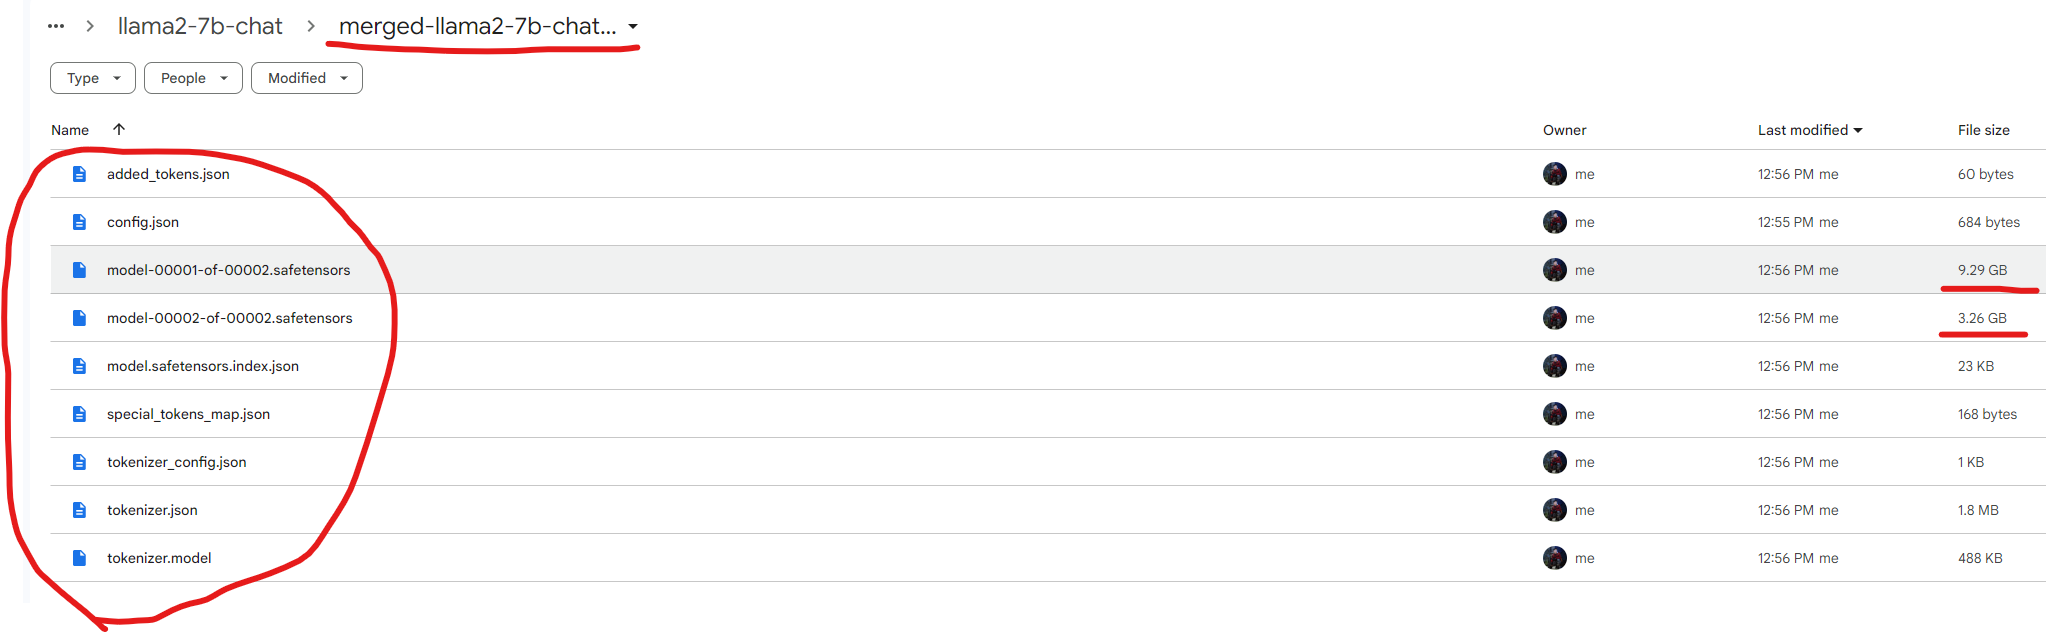

## 5. Run inference using the merged model

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

merged_model_folder = "./merged-llama2-7b-chat-ml/checkpoint-1875"
tokenizer = AutoTokenizer.from_pretrained(merged_model_folder)

model = AutoModelForCausalLM.from_pretrained(    # took 3.5 min to load with L4 GPU
    merged_model_folder,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
    device_map="auto",
)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# print(model)

In [7]:
# Create a generation_config.json and save it to the merged model path

import os
import json
from transformers import pipeline, GenerationConfig

# Define generation configuration and set default values
generation_config_dict = {
    "max_new_tokens": 512,
    "temperature": 1.0,
    "repetition_penalty": 1.0,  # penalty for word repetition
    "pad_token_id": tokenizer.eos_token_id
}

# Convert the dictionary to a JSON formatted string
generation_config_json = json.dumps(generation_config_dict, indent=4)

# Save the JSON string to a file named generation_config.json
config_file_path = os.path.join(merged_model_folder, "generation_config.json")
with open(config_file_path, "w") as config_file:
    config_file.write(generation_config_json)



Load the test dataset

In [8]:
# load the data locally

import json

# load the whole dataset
with open('/content/gdrive/My Drive/Practice/4/ml-arxiv-papers/alldata.json', 'r', encoding='utf-8') as file:  # open from absolute path 绝对路径
    alldata = json.load(file)
print("# Total alldata samples:", len(alldata))
print()

# split test set
test_dataset = alldata[42000:43000]  # alldata[42000:43000]
print("# test_dataset samples:", len(test_dataset))
print("test_dataset 1st sample:", test_dataset[0])


# Total alldata samples: 43713

# test_dataset samples: 1000
test_dataset 1st sample: {'id': 112194, 'context': 'Neural Mesh: Introducing a Notion of Space and Conservation of Energy to   Neural Networks.Neural networks are based on a simplified model of the brain. In this project, we wanted to relax the simplifying assumptions of a traditional neural network by making a model that more closely emulates the low level interactions of neurons. Like in an RNN, our model has a state that persists between time steps, so that the energies of neurons persist. However, unlike an RNN, our state consists of a 2 dimensional matrix, rather than a 1 dimensional vector, thereby introducing a concept of distance to other neurons within the state. In our model, neurons can only fire to adjacent neurons, as in the brain. Like in the brain, we only allow neurons to fire in a time step if they contain enough energy, or excitement. We also enforce a notion of conservation of energy, so that a neuron canno

In [9]:
sample = test_dataset[3]

# From experience: during inference, exclude <s> and </s> in the prompt, as the model will generate them as special tokens
prompt = f"""[INST] <<SYS>>
You are a helpful, respectful and honest assistant. \
Your task is to generate an answer to the given question. \
And your answer should be based on the provided context only.
<</SYS>>

### Question: {sample['question']}
### Context: {sample['context']} [/INST]
### Answer:
"""

print(prompt)


[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Your task is to generate an answer to the given question. And your answer should be based on the provided context only.
<</SYS>>

### Question: How are Gated Transformer Networks for Multivariate Time Series Classification structured?
### Context: Gated Transformer Networks for Multivariate Time Series Classification.Deep learning model (primarily convolutional networks and LSTM) for time series classification has been studied broadly by the community with the wide applications in different domains like healthcare, finance, industrial engineering and IoT. Meanwhile, Transformer Networks recently achieved frontier performance on various natural language processing and computer vision tasks. In this work, we explored a simple extension of the current Transformer Networks with gating, named Gated Transformer Networks (GTN) for the multivariate time series classification problem. With the gating that merges two towers of Tr

Inference

In [10]:
# Inference code 1 (this code better):

# Initialize generation configuration object
gen_config = GenerationConfig.from_dict(generation_config_dict)

# Modify generation configuration for pipeline
gen_config.max_new_tokens = 128  # larger max_new_tokens, longer inference
gen_config.temperature = 0.8
gen_config.repetition_penalty = 1.2

# Initialize pipeline
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map='auto',
    generation_config=gen_config,
)


# Inference using pipeline
output = pipe(prompt)
generated_answer = output[0]['generated_text'][len(prompt):]

print('\nQuestion:\n', sample['question'])
print('\nGround truth:\n', sample['answer'])
print('\nGenerated answer:\n', generated_answer)


/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:224: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')



Question:
 How are Gated Transformer Networks for Multivariate Time Series Classification structured?

Ground truth:
 Gated Transformer Networks (GTN) integrate gating mechanisms into traditional transformer architecture, merging two towers modeling channel-wise and step-wise correlations. This structure enables GTN to effectively handle multivariate time series classification tasks by capturing complex dependencies within the data. The gating mechanism enhances the network's capability to learn from multiple sources of information simultaneously, leading to improved performance compared to existing deep learning models. By combining the strengths of both transformers and gating mechanisms, GTN demonstrates competitive results in experiments across thirteen datasets, positioning it as a strong contender among state-of-the-art models for time series classification.

Generated answer:
 Gated Transformer Networks (GTN) extend Transformer Networks by introducing gating mechanisms to merge

In [ ]:
# # Inference code 2:

# # encode prompt
# input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

# # generate output
# outputs = model.generate(input_ids=input_ids, max_new_tokens=128, temperature=0.8)  # max_new_tokens=128, larger max_new_tokens longer inference

# # decode output
# model_output = tokenizer.decode(outputs[0])
# generated_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0][len(prompt):]

# print('\nModel output:\n', model_output)  # decoded_output
# print("___" * 20)

# print('\nGround truth:\n', sample['answer'])
# print('\nGenerated answer:\n', generated_answer)




Model output:
 <s> [INST] <<SYS>>
You are a helpful, respectful and honest assistant. Your task is to generate an answer to the given question. And your answer should be based on the provided context only.
<</SYS>>

### Question: How are Gated Transformer Networks for Multivariate Time Series Classification structured?
### Context: Gated Transformer Networks for Multivariate Time Series Classification.Deep learning model (primarily convolutional networks and LSTM) for time series classification has been studied broadly by the community with the wide applications in different domains like healthcare, finance, industrial engineering and IoT. Meanwhile, Transformer Networks recently achieved frontier performance on various natural language processing and computer vision tasks. In this work, we explored a simple extension of the current Transformer Networks with gating, named Gated Transformer Networks (GTN) for the multivariate time series classification problem. With the gating that mer

Inference on the whole testset and save the results (1000 samples, L4 GPU usage 5.2G, duration 2h 31min, speed 9.1 s/sample)

In [11]:
import json

# Check if the result file already exists, if not, create an empty list
if not os.path.exists("./test_dataset_inference_results_1_1875.json"):
    with open("./test_dataset_inference_results_1_1875.json", "w") as f:
        json.dump([], f)

# Loop over all samples in test_dataset
for i in range(len(test_dataset)):
    # sample = dataset["validation"][i]
    sample = test_dataset[i]
    prompt = f"""[INST] <<SYS>>
You are a helpful, respectful and honest assistant. \
Your task is to generate an answer to the given question. \
And your answer should be based on the provided context only.
<</SYS>>

### Question: {sample['question']}
### Context: {sample['context']} [/INST]
### Answer:
"""    # experience: here exlcude the </s> in the prompt during inference, and you get better results

    output = pipe(prompt)
    generated_answer = output[0]['generated_text'][len(prompt):]

    # add the results into a list
    result = {
        'id': sample['id'],
        'question': sample['question'],
        'ground_truth': sample['answer'],
        'answer': generated_answer
    }

    # Read existing results
    with open("./test_dataset_inference_results_1_1875.json", "r") as f:
        existing_results = json.load(f)

    # Append new result to the existing result list
    existing_results.append(result)

    # Write results to file
    with open("./test_dataset_inference_results_1_1875.json", "w") as f:
        json.dump(existing_results, f)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [12]:
# Load and check the results JSON file

import json

with open("./test_dataset_inference_results_1_1875.json", "r") as f:
    test_dataset_inference_results = json.load(f)
print("# results samples:", len(test_dataset_inference_results))

# Check results
test_dataset_inference_results[:2]


# results samples: 1000


[{'id': 112194,
  'question': 'What is the unique feature of the Neural Mesh architecture?',
  'ground_truth': 'The unique feature of the Neural Mesh architecture is the introduction of a 2 dimensional matrix state for neurons, which introduces a notion of spatial distance to other neurons within the network. This allows neurons to only fire to adjacent neurons, mimicking the interactions in the brain. Additionally, the model enforces a conservation of energy principle, ensuring that neurons cannot excite their neighbors more than their existing excitement level. These innovations enable signals in the form of activations to flow around the network over time, closely mirroring how signals travel through the brain.',
  'answer': 'The unique feature of the Neural Mesh architecture lies in incorporating a notion of space with a 2-dimensional matrix representing the state of neurons. This allows for a closer resemblance to the way neurons interact in the brain, where neurons can only fire 

## 6. Evaluate the model performance

- semantic-level similarity (METEOR and BERTScore)
- word and sequence level overlap (BLEU and ROUGE scores)
- human evaluation

(See another Jupyter notebook for details)